In [23]:
#Step 1: Get Satellite Imagery from Google Earth Engine
# Import necessary libraries

import ee
import geemap
import os

# Initialize Earth Engine
ee.Initialize()

# Define a simple bounding box geometry for testing
bbox_coords = ((11.437948183612978, 47.55891195678332), (11.484581611702358, 47.56320074444652))
geometry = ee.Geometry.Polygon([
    [
        [bbox_coords[0][0], bbox_coords[0][1]],  # (xmin, ymin)
        [bbox_coords[0][0], bbox_coords[1][1]],  # (xmin, ymax)
        [bbox_coords[1][0], bbox_coords[1][1]],  # (xmax, ymax)
        [bbox_coords[1][0], bbox_coords[0][1]],  # (xmax, ymin)
        [bbox_coords[0][0], bbox_coords[0][1]],  # Closing the polygon
    ]
])

# Check geometry (print the polygon coordinates)
print(geometry.getInfo())


def extract_timestamp(image):
    # Get the system:index of the image
    index = image.get('id')
    timestamp = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    
    # Split the index to extract the timestamp (first 8 characters: YYYYMMDD)
    #split_parts = index.split('/')
    #date_part = split_parts[2][:8]
    #formatted_date = f"{date_part[:4]}-{date_part[4:6]}-{date_part[6:8]}"

    # Return the image with a new 'timestamp' property
    return image.set('timestamp', timestamp)

# Define NDWI calculation function (normalized difference using B3 and B8)
def calculateNDWI(image):
    ndwi = image.normalizedDifference(["B3", "B8"]).rename("NDWI")
    return image.addBands(ndwi)

# Define a function to clip the image to your geometry
def clip_image(image):
    return image.clip(geometry)
# Create a function to assign a chronological image_id based on the collection index
def create_feature_with_index(image, index):
    # Convert the index to a string to be used as the image ID
    image_id = ee.Number(index)  # Using index as the image ID
    timestamp = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')  # Format timestamp as YYYY-MM-DD
    
    # Create a feature with the image ID and timestamp
    feature = ee.Feature(None, {
        'image_id': image_id,
        'timestamp': timestamp
    })
    return feature

# Function to assign a chronological index to each image in the collection
def add_index_to_collection(image_collection):
    # Create a list of features with image_id as index
    def assign_index(image, index):
        return create_feature_with_index(image, index)
    
    # Map the function over the collection and add indices
    feature_collection = image_collection.map(lambda image: assign_index(image, image_collection.toList(image_collection.size()).indexOf(image)))
    return feature_collection



# Load Sentinel-2 image collection
sentinel = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterDate('2022-05-01', '2022-10-31') \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Optional: filter out high cloud coverage


# Create an export folder (if it doesn't exist)
#output_folder = '/Users/evaschmidt/Documents/Preprocessing_SatelliteImagery/GEE_Images/'  # Folder where you want to save the images
# Map the functions: clip each image and calculate NDWI
processed_images = sentinel.map(clip_image).map(calculateNDWI)
# Map the function over the processed image collection to create a FeatureCollection with chronological image_ids
features = add_index_to_collection(processed_images)

# Export the FeatureCollection as a CSV to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=features,
    description='Image_Metadata',
    fileFormat='CSV',
    folder='GEE_Images_test',  # Folder in your Google Drive
    fileNamePrefix='satellite_metadata_test_summer',
)

# Start the export task
export_task.start()

print("Export task for image metadata started. Monitor Earth Engine for task completion.")


# Export each image in the collection
def export_image(image, idx):
    # Extract the timestamp (formatted date) from the image
    #

    #date_str = image.get('timestamp')  # Ensure it fetches the value as a string
    #date_str = index2[17:25]
    #split_parts = index2.split('/')
    #date_part = split_parts[2][:8]
    #date_str = f"{date_part[:4]}-{date_part[4:6]}-{date_part[6:8]}"
    #filename = os.path.join(output_folder, f"NDWI_{date_str}_{idx}.tif")
        
    # Export the image to a GeoTIFF using Earth Engine's export method
    export_task = ee.batch.Export.image.toDrive(
        image=image.select("NDWI"),
        description=None,
        folder="GEE_Images_test_summer",
        fileNamePrefix=f"NDWI_{idx}",
        region=geometry,
        scale=10,
        crs='EPSG:4326',
        maxPixels=1e8  # Increase the max pixels if necessary
    )
    export_task.start()  # Start the export task
    print(f"Exporting {idx}")

# Convert the image collection to a list of images (this triggers the actual fetching of the collection)
image_list = processed_images.toList(processed_images.size())

# Loop through the image collection and export each image
for idx in range(image_list.size().getInfo()):
    ee_image = ee.Image(image_list.get(idx))  # Get the image by its index in the list
    export_image(ee_image, idx)

print("Export tasks started. Monitor Earth Engine for task completion.")


{'type': 'Polygon', 'coordinates': [[[11.437948183612978, 47.55891195678332], [11.484581611702358, 47.55891195678332], [11.484581611702358, 47.56320074444652], [11.437948183612978, 47.56320074444652], [11.437948183612978, 47.55891195678332]]]}


/Users/evaschmidt/Documents/Preprocessing_SatelliteImagery/river_analysis_env/lib/python3.11/site-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


Export task for image metadata started. Monitor Earth Engine for task completion.
Exporting 0
Exporting 1
Exporting 2
Exporting 3
Exporting 4
Exporting 5
Exporting 6
Exporting 7
Exporting 8
Exporting 9
Exporting 10
Exporting 11
Exporting 12
Exporting 13
Exporting 14
Exporting 15
Exporting 16
Exporting 17
Exporting 18
Exporting 19
Exporting 20
Exporting 21
Exporting 22
Export tasks started. Monitor Earth Engine for task completion.


In [ ]:
# Step 2: Add an index column to the existing CSV file --> Not necessary due to column image_id

import pandas as pd

# Lade deine bestehende CSV-Datei
metadata_path = 'Metadata_test_summer.csv'  # Pfad zu deiner Metadata.csv-Datei
metadata_df = pd.read_csv(metadata_path)

# Erstelle eine neue Spalte 'Index' mit aufsteigenden Werten beginnend bei 0
metadata_df['Index'] = range(len(metadata_df))

# Speichern der Datei mit der neuen Index-Spalte
output_path = 'Metadata_test_summer_with_index.csv'  # Pfad zum Speichern der neuen CSV-Datei
metadata_df.to_csv(output_path, index=False)

print(f"Neue Spalte 'Index' hinzugefügt und gespeichert unter: {output_path}")


Neue Spalte 'Index' hinzugefügt und gespeichert unter: Metadata_test_summer_with_index.csv


In [44]:
# Step 3: Process the images and create water masks


import os
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt

# Schritt 1: Funktion zum Extrahieren der ID aus dem Dateinamen (z.B. "NDWI_06.tif" -> ID 06)
def extract_id_from_filename(filename):
    return int(filename.split('_')[1].split('.')[0])  # Extrahiert die ID aus dem Dateinamen

# Schritt 2: Funktion, um den Timestamp aus einer CSV-Datei anhand der ID zu holen
def get_timestamp_from_id(image_id):
    timestamp_data = pd.read_csv('Metadata_test_summer_with_index.csv')  # Pfad zur CSV-Datei mit Timestamps
    row = timestamp_data[timestamp_data['Index'] == image_id]
    if not row.empty:
        return row['timestamp'].values[0]
    else:
        return None  # Falls keine passende ID gefunden wurde

# Schritt 3: Verarbeiten der Watermasks
def process_images_and_create_water_masks(folder_path):
    output_dir_water_masks = 'water_masks_test_summer/'  # Ordner für Wasser-Masken

    # Sicherstellen, dass der Ordner für Wasser-Masken existiert
    if not os.path.exists(output_dir_water_masks):
        os.makedirs(output_dir_water_masks)

    # Iteriere über die Bilder im Ordner
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.tif', '.tiff')):
            # Extrahieren der ID und des Timestamps
            image_id = extract_id_from_filename(filename)
            timestamp = get_timestamp_from_id(image_id)
            if timestamp is None:
                print(f"Kein Timestamp gefunden für Bild {filename}. Überspringe.")
                continue
            
            # Öffne das Bild
            file_path = os.path.join(folder_path, filename)
            dataset = gdal.Open(file_path)
            if dataset is None:
                print(f"Fehler beim Öffnen der Datei: {filename}")
                continue
            
            # Hole das NDWI-Band (erste Band)
            band = dataset.GetRasterBand(1)
            ndwi = band.ReadAsArray()
            
            # Erstelle eine binäre Wasser-Maske basierend auf NDWI
            water_mask = ndwi > 0.0  # Beispielhafte Schwelle für Wasser (NDWI > 0)
        
            # Speicher die Wasser-Maske als GeoTIFF
            water_mask_filename = os.path.join(output_dir_water_masks, f"water_mask_{os.path.splitext(filename)[0]}.tif")
            driver = gdal.GetDriverByName('GTiff')
            mask_dataset = driver.Create(
                water_mask_filename,
                dataset.RasterXSize,
                dataset.RasterYSize,
                1,
                gdal.GDT_Byte
            )
            mask_dataset.SetGeoTransform(dataset.GetGeoTransform())
            mask_dataset.SetProjection(dataset.GetProjection())
            mask_band = mask_dataset.GetRasterBand(1)
            mask_band.WriteArray(water_mask.astype(np.uint8))  # Speichern der binären Maske als TIFF
            mask_dataset = None
            print(f"Saved water mask: {water_mask_filename}")

    print("Alle Wasser-Masken wurden verarbeitet und gespeichert.")
    return

# Schritt 4: Beispielaufruf der Funktion (benutze deinen spezifischen Ordner und die Pfade)
folder_path = 'GEE_Images_test_summer/'  # Pfad zu den Satellitenbildern
#output_folder = 'Labeled_Maps_Isar_test/'  # Pfad zum Ausgabeordner für Labeled Maps

# Verarbeite die Bilder und erstelle die Wasser-Masken
process_images_and_create_water_masks(folder_path)




Saved water mask: water_masks_test_summer/water_mask_NDWI_7.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_20.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_21.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_6.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_4.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_22.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_5.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_1.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_0.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_2.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_19.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_18.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_3.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_15.tif
Saved water mask: water_masks_test_summer/water_mask_NDWI_14.tif
Saved water mask: water_masks_tes

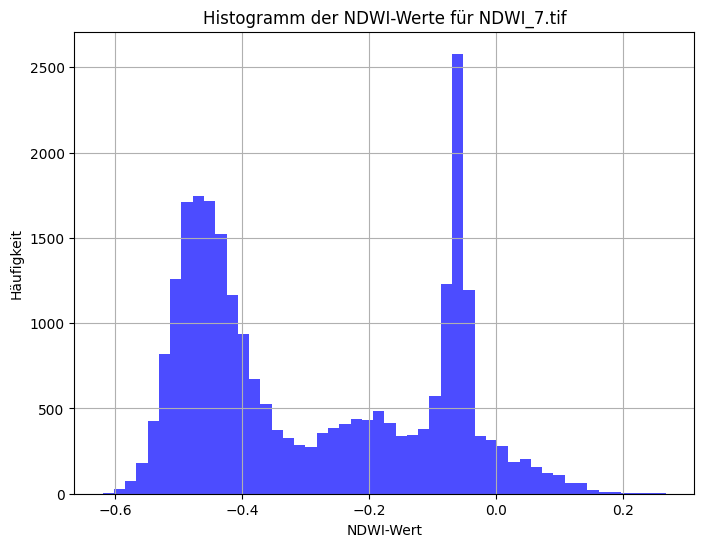

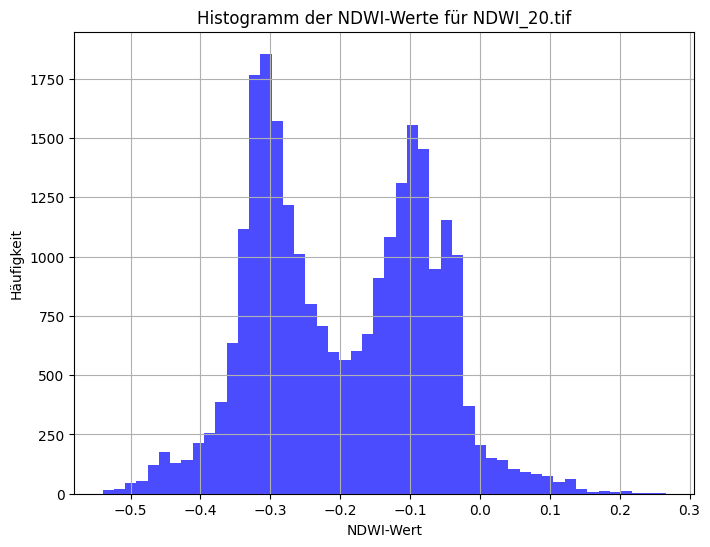

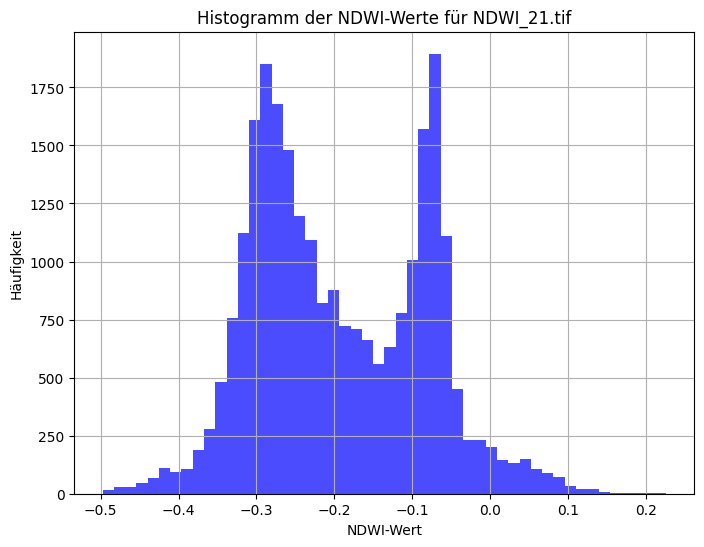

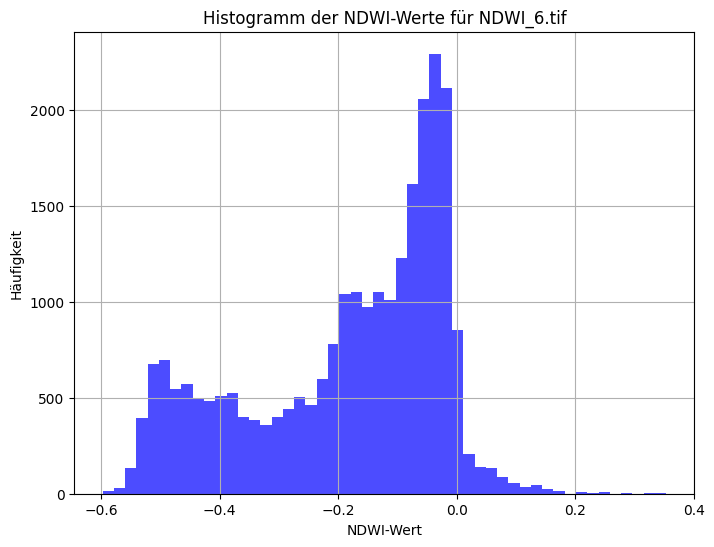

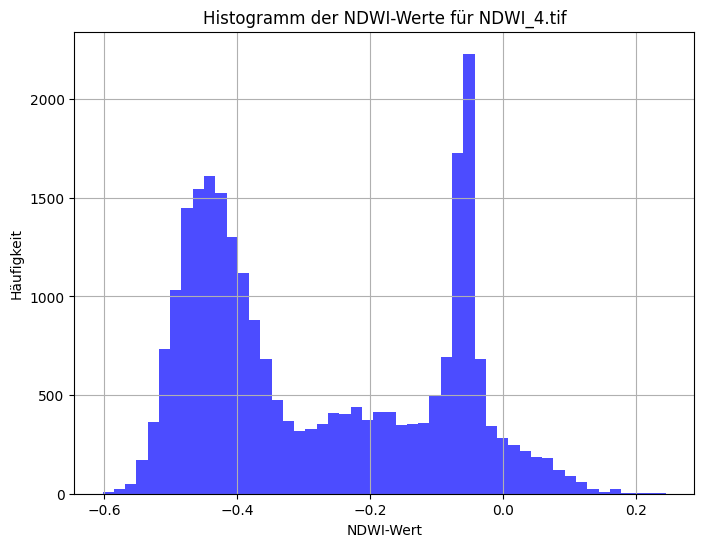

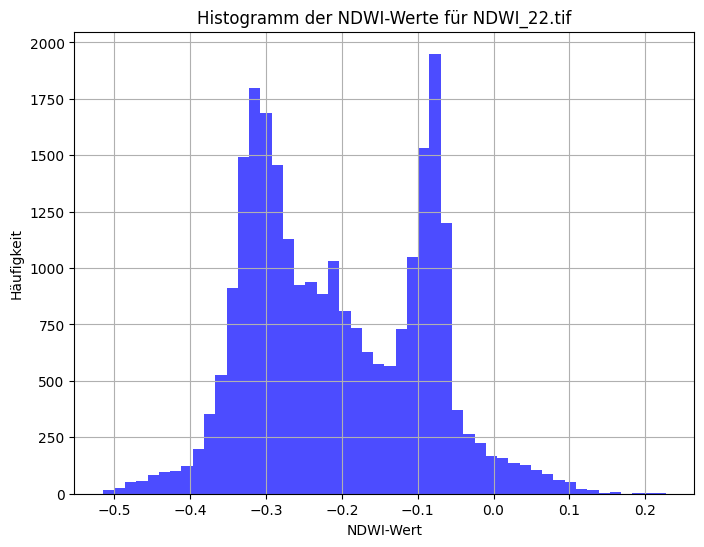

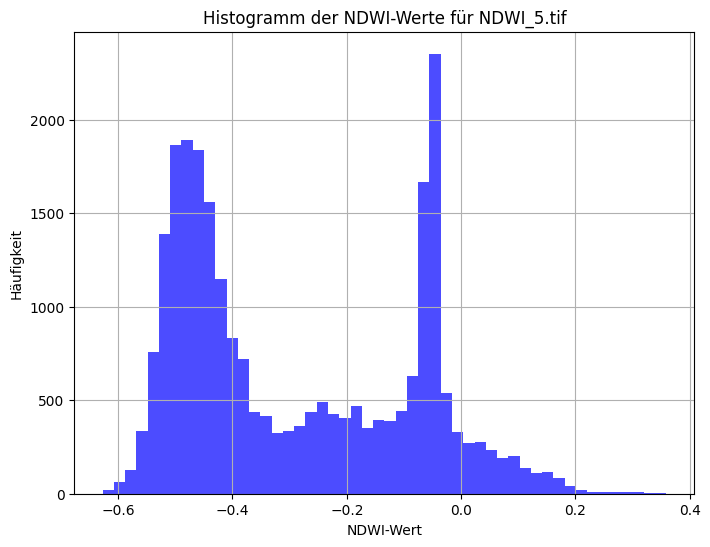

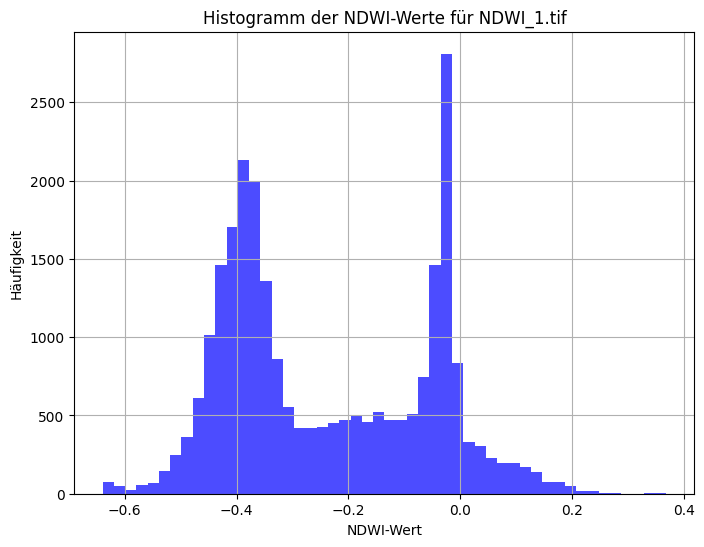

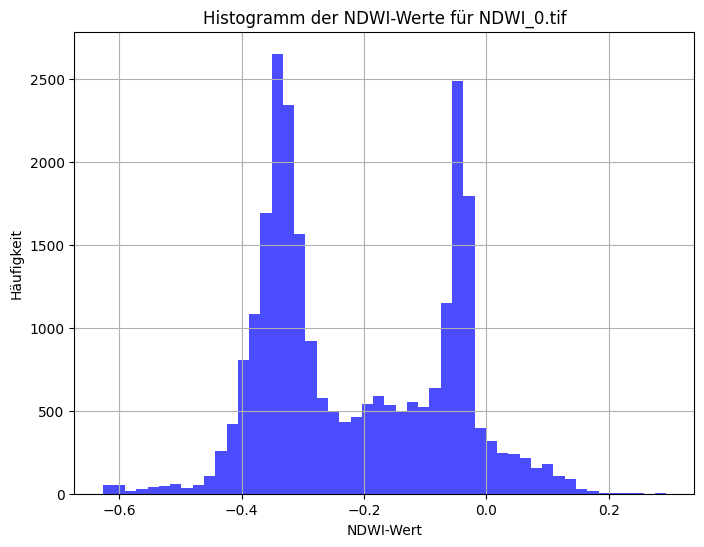

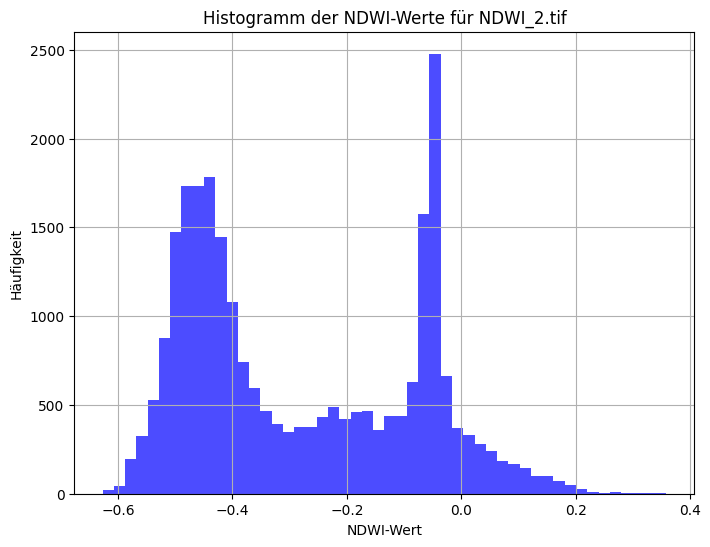

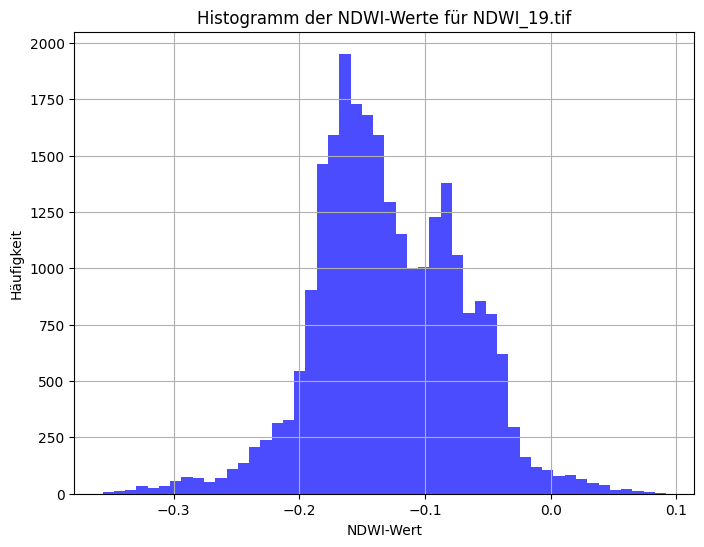

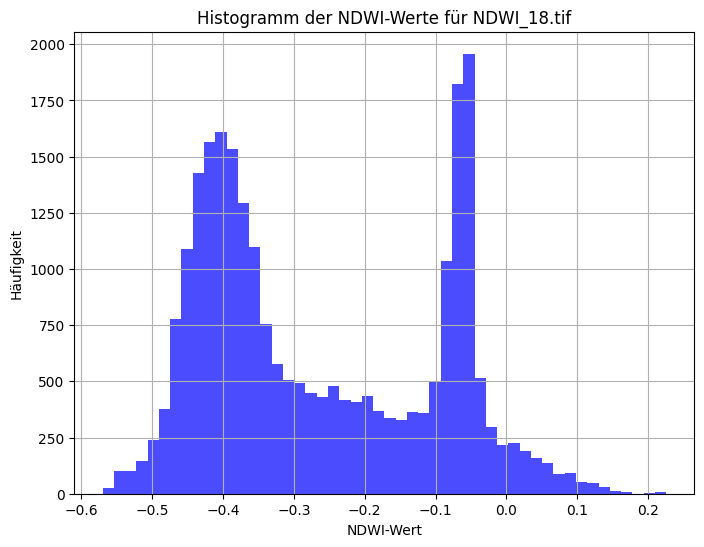

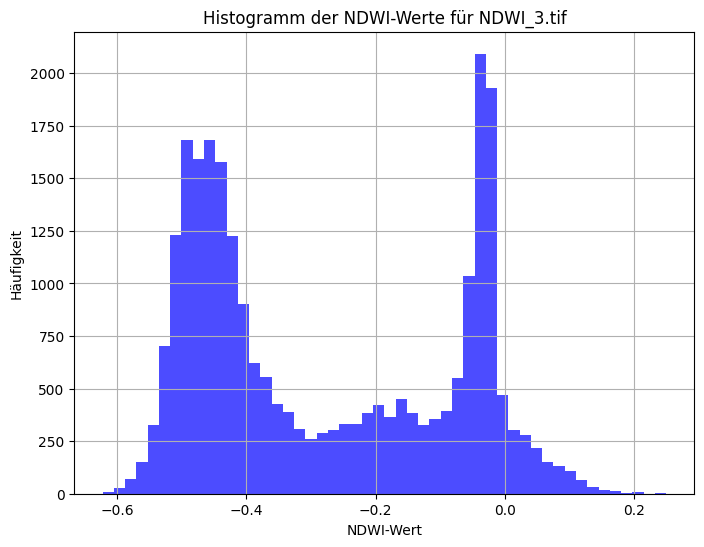

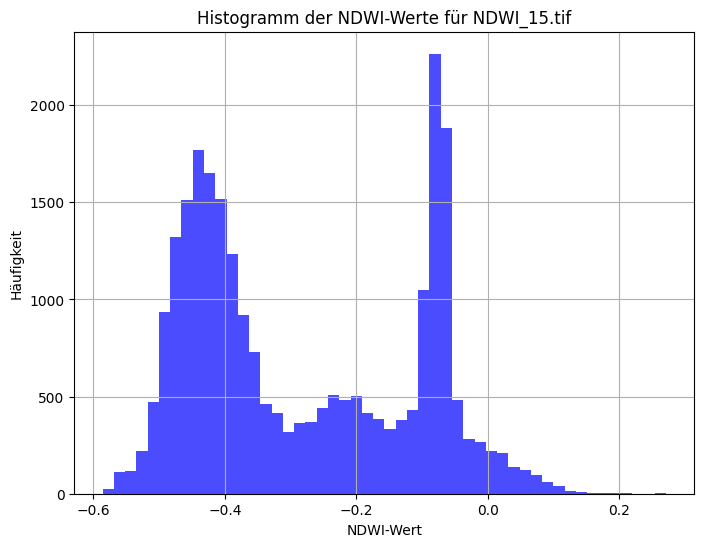

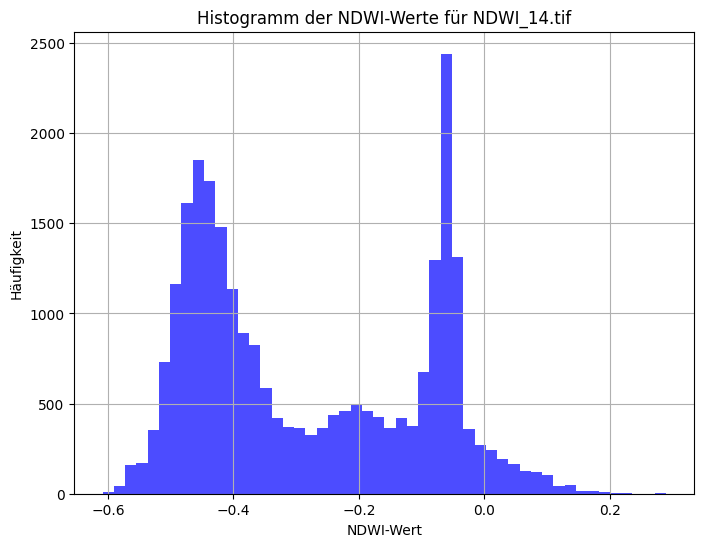

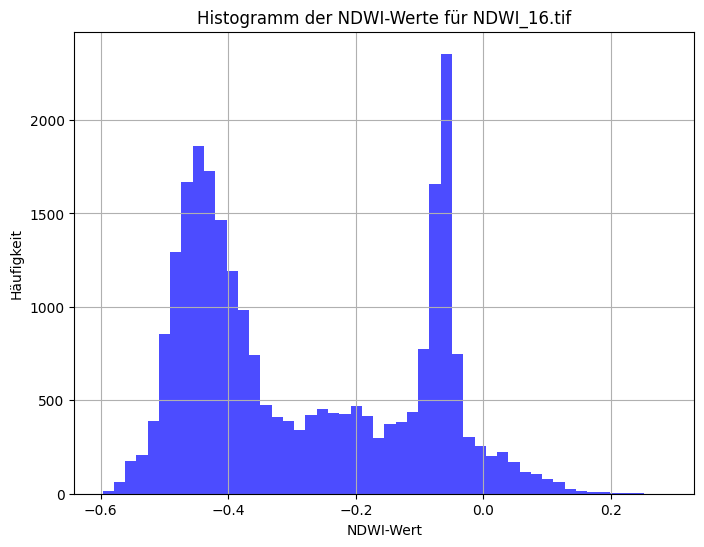

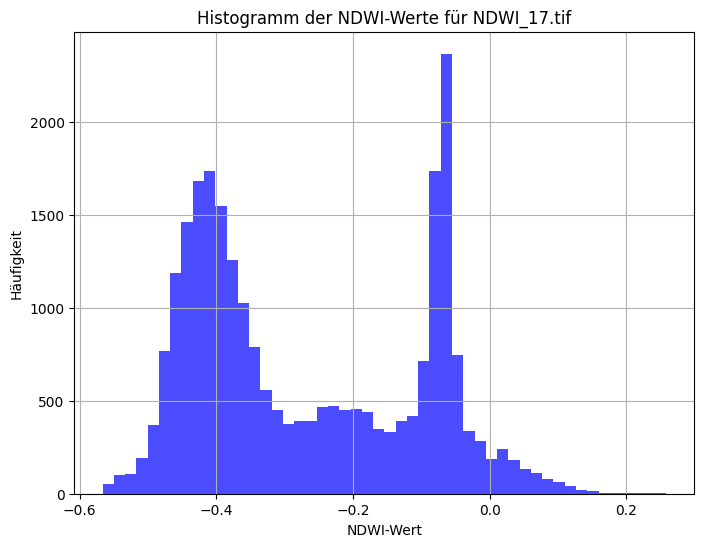

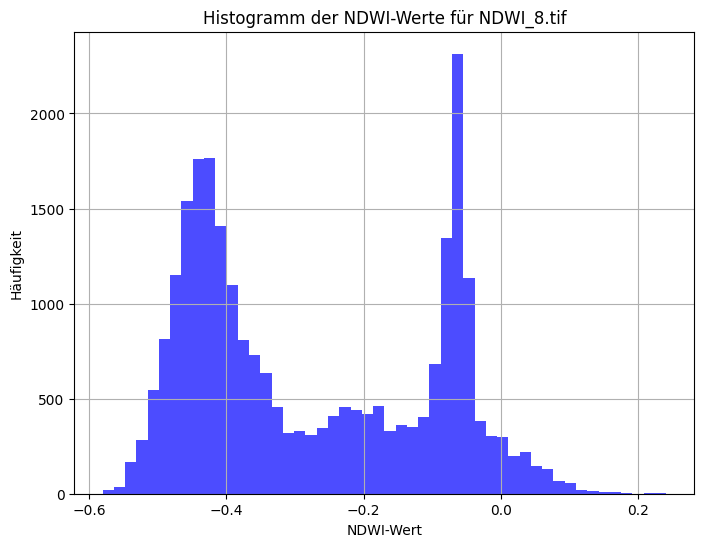

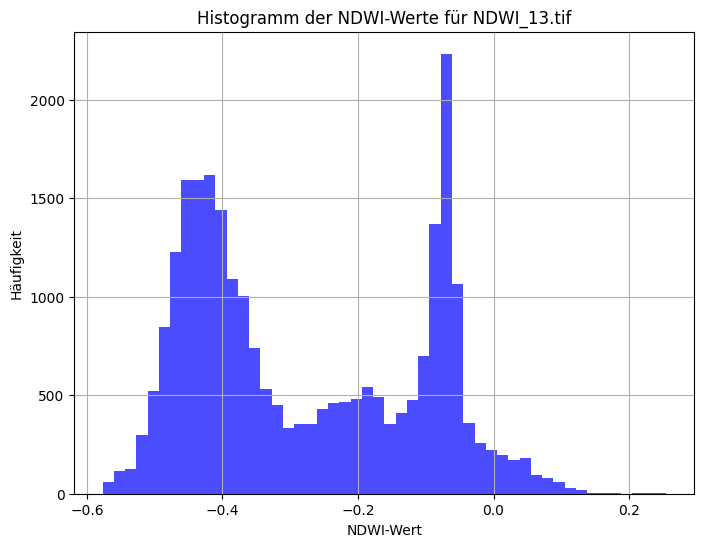

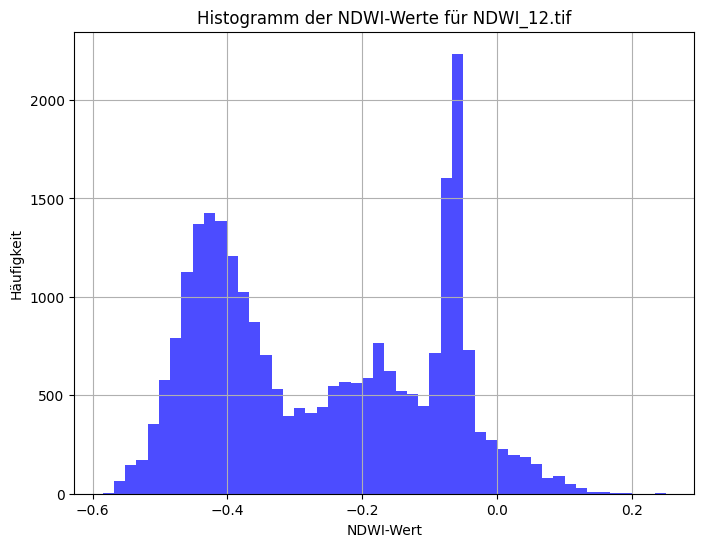

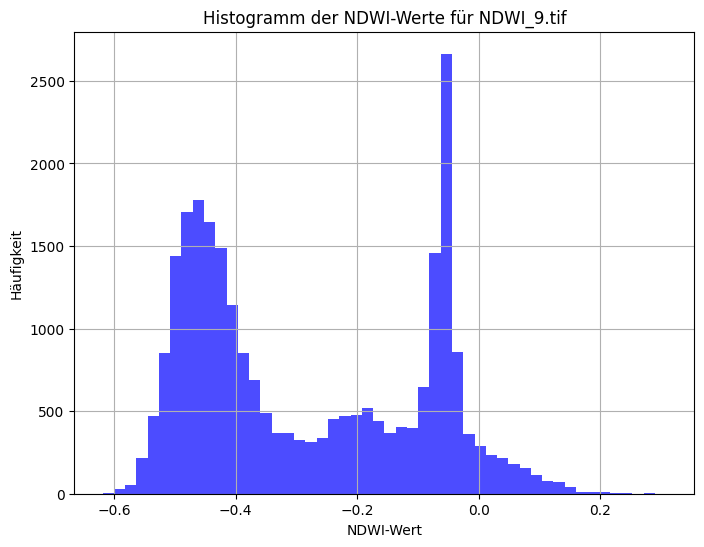

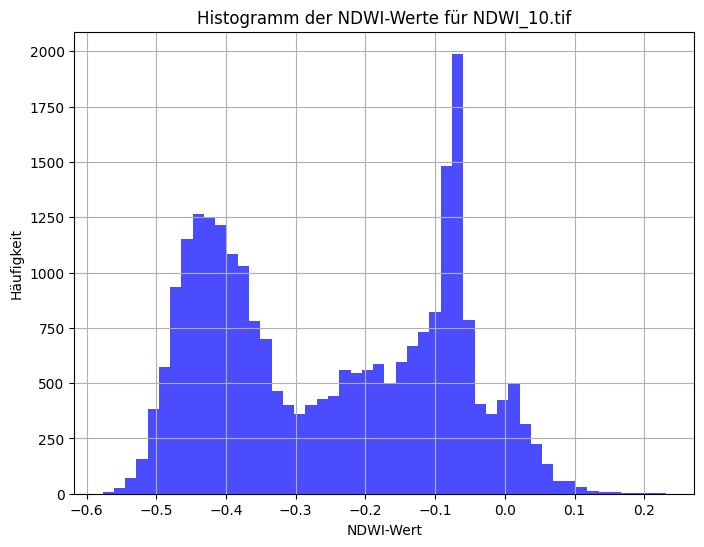

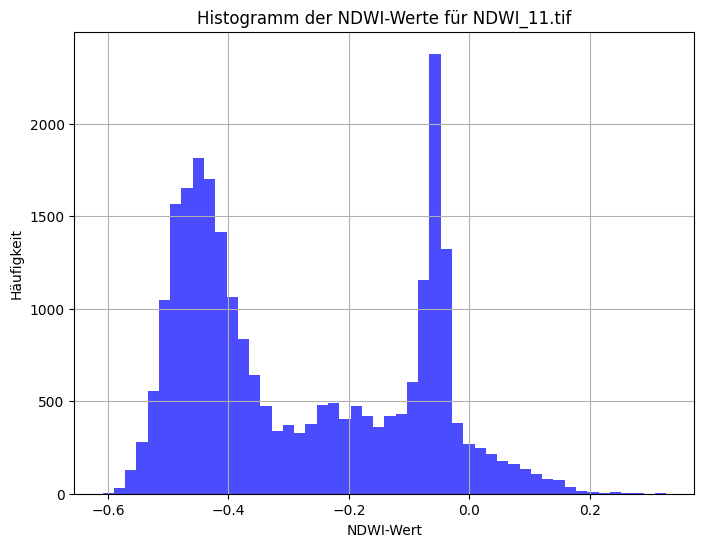

In [ ]:
#Step in between: We need to find a individual NDWI threshold for each image to create a water mask --> We create a function of f(waterlevel) = amount of 
# water in the image and then calculate the NDWI-threshold as the x.th percentil 

import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Funktion zum Laden eines NDWI-Bildes
def load_ndwi_image(file_path):
    with rasterio.open(file_path) as src:
        # Lade das NDWI-Bild (wir nehmen an, dass es ein Einzelband-Bild ist)
        ndwi = src.read(1)  # Wir lesen das erste Band, falls NDWI im ersten Band gespeichert ist
    return ndwi

# Funktion, um alle NDWI-Bilder im Ordner zu laden und die Histogramme anzuzeigen
def load_and_plot_histograms_for_each_ndwi_image(folder_path):
    # Iteriere über alle Dateien im Ordner
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.tif', '.tiff')):
            # Erstelle den vollständigen Dateipfad
            file_path = os.path.join(folder_path, filename)
            
            # Lade das NDWI-Bild
            ndwi = load_ndwi_image(file_path)
            
            # Erstelle das Histogramm der NDWI-Werte für dieses Bild
            plt.figure(figsize=(8, 6))
            plt.hist(ndwi.flatten(), bins=50, color='blue', alpha=0.7)
            plt.title(f"Histogramm der NDWI-Werte für {filename}")
            plt.xlabel("NDWI-Wert")
            plt.ylabel("Häufigkeit")
            plt.grid(True)
            plt.show()

# Beispielaufruf der Funktion
folder_path = 'GEE_Images_test_summer/'  # Ordner mit deinen NDWI-Bildern
load_and_plot_histograms_for_each_ndwi_image(folder_path)


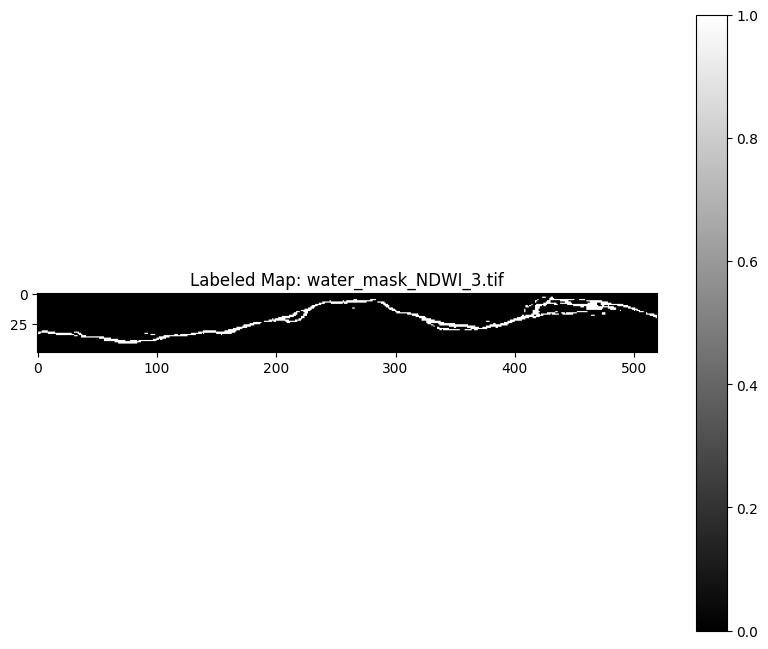

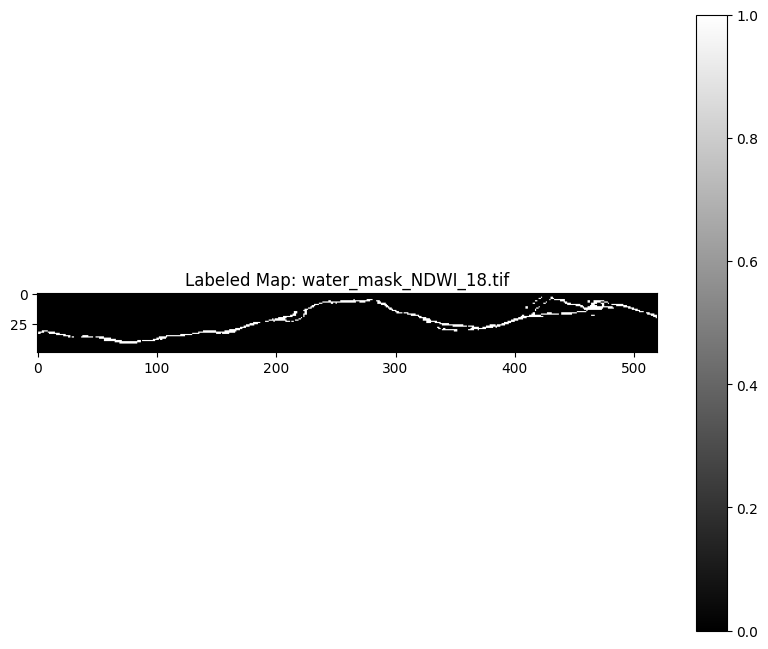

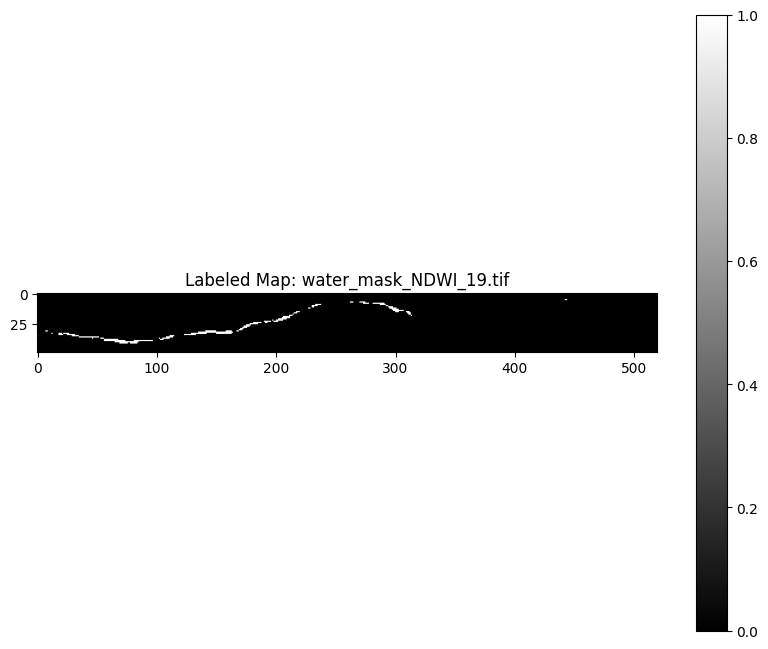

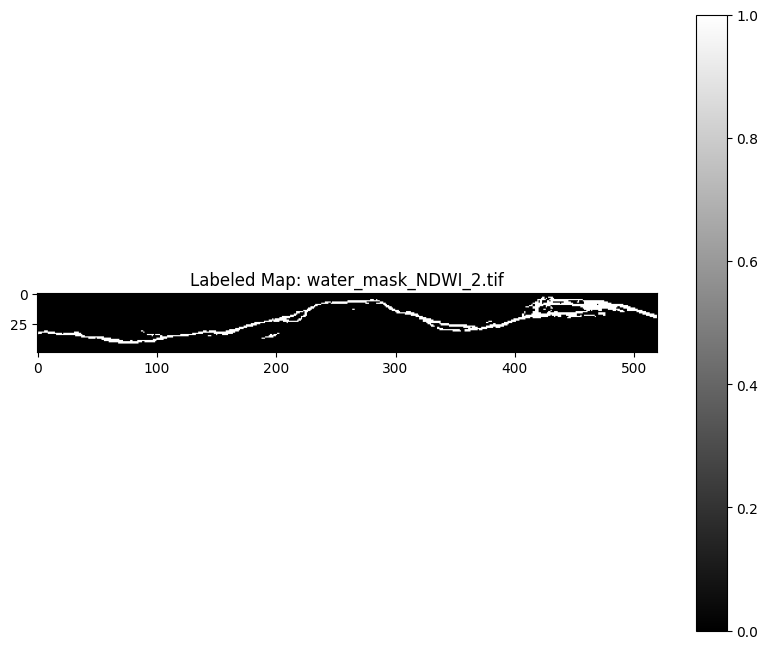

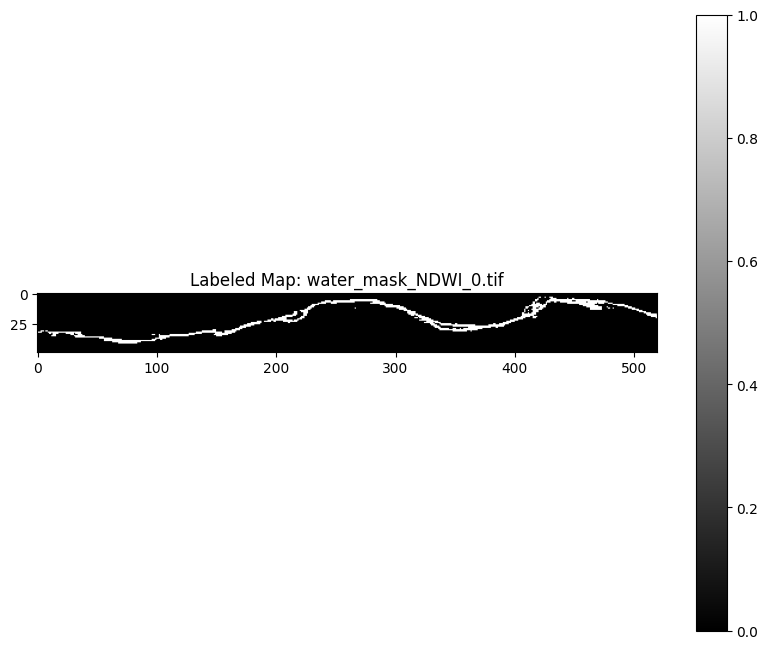

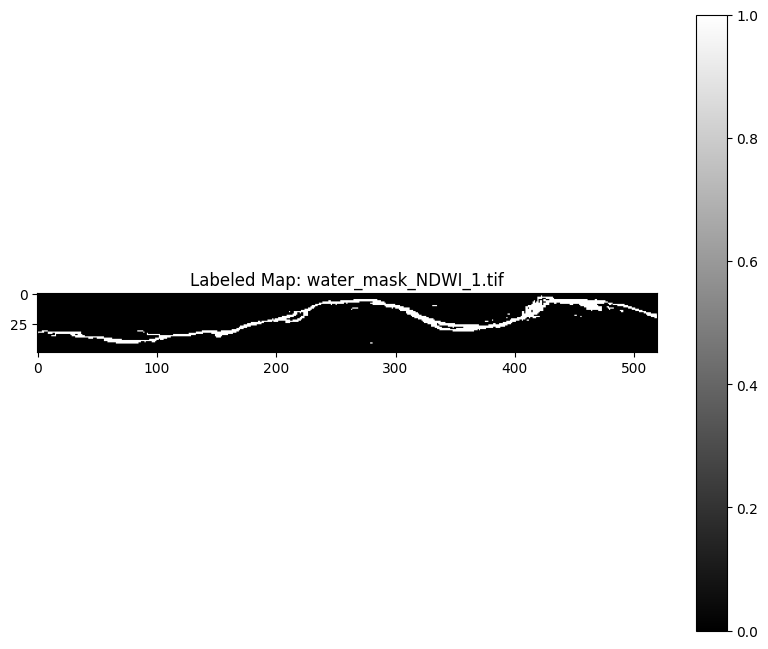

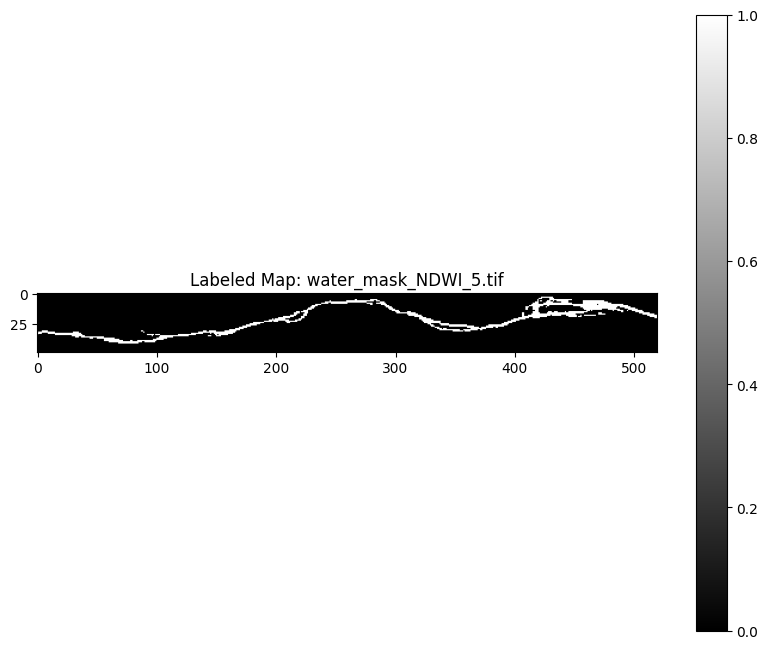

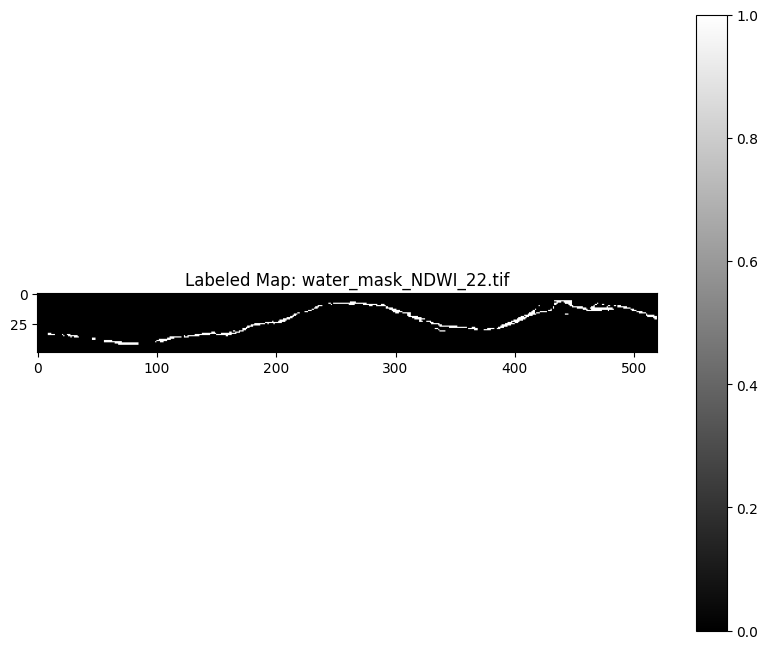

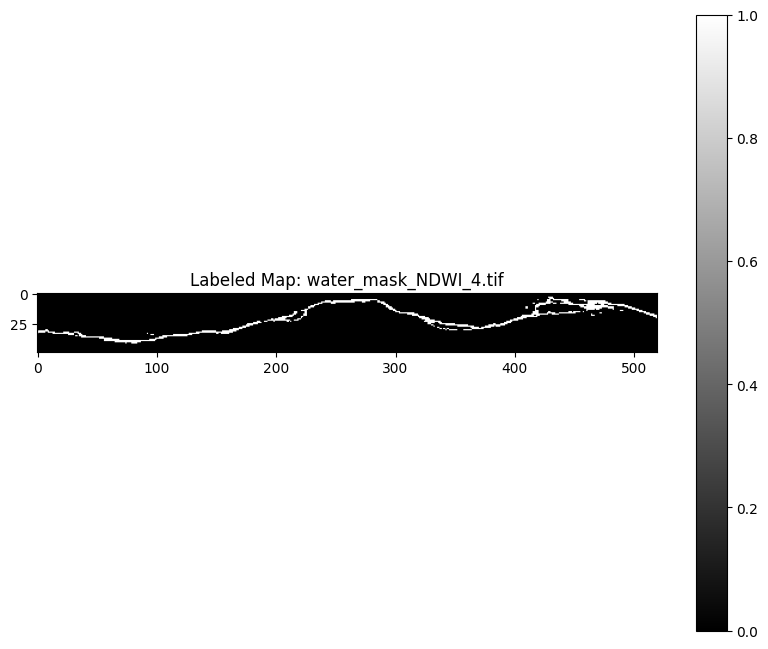

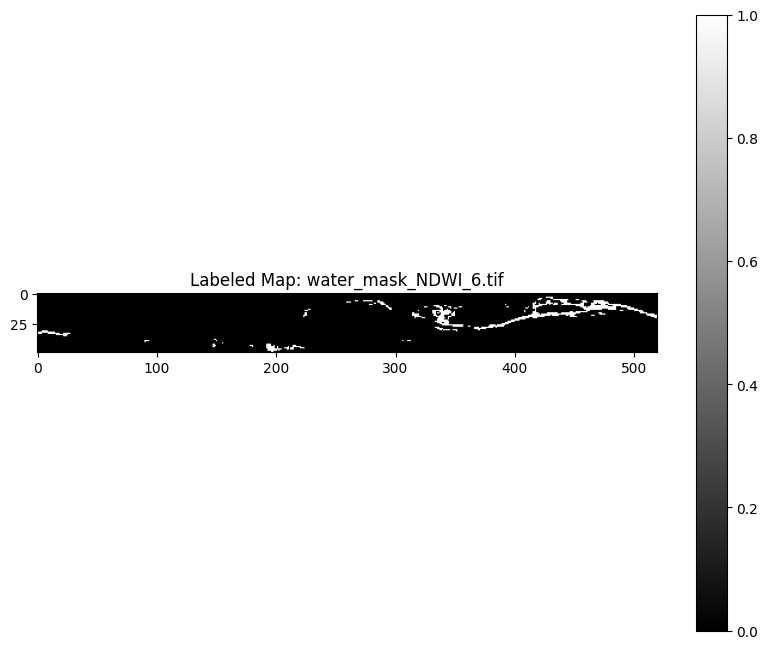

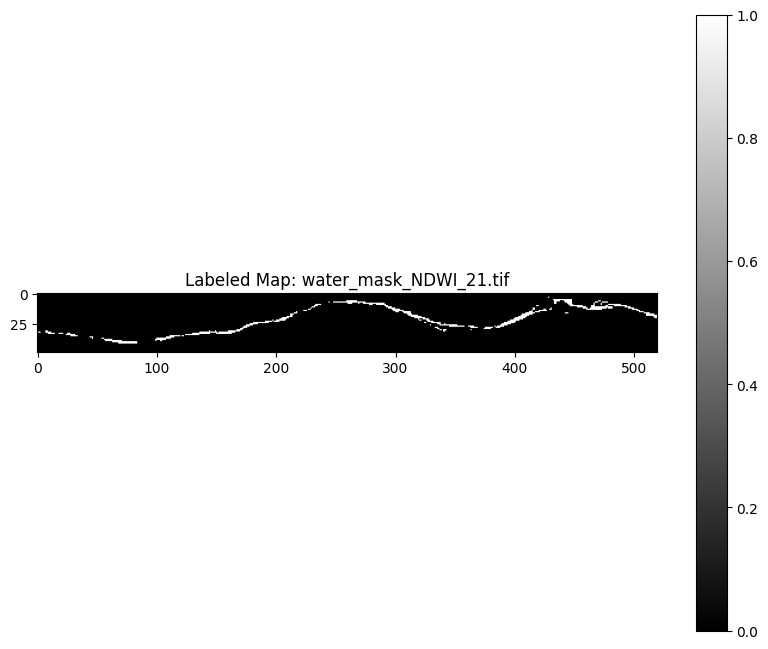

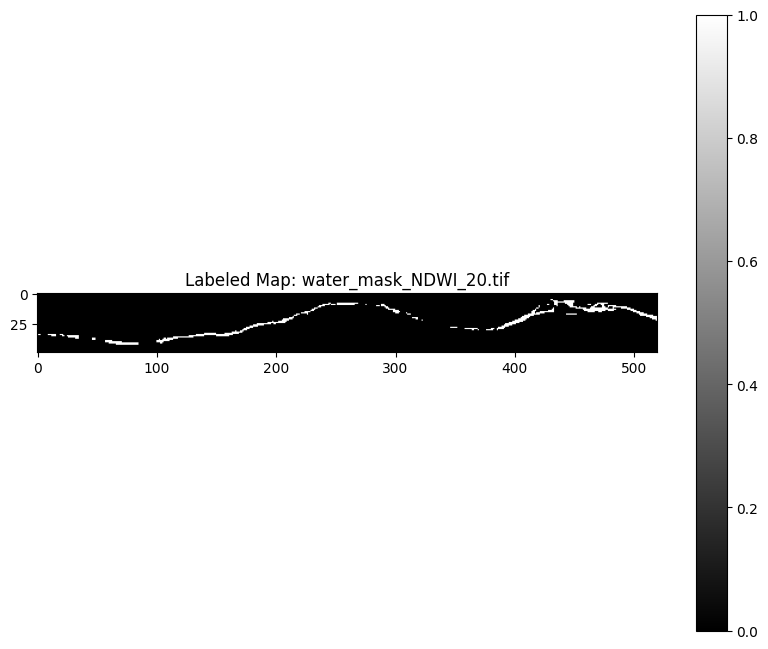

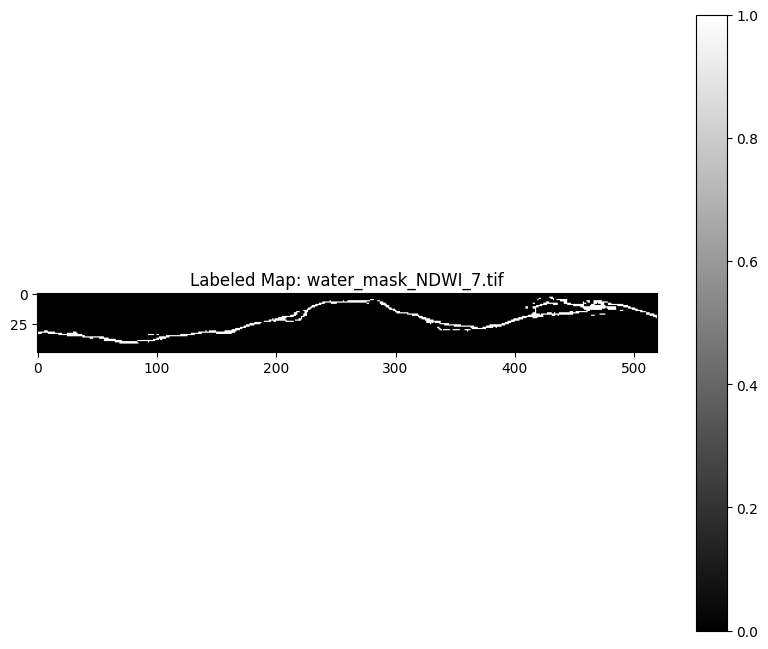

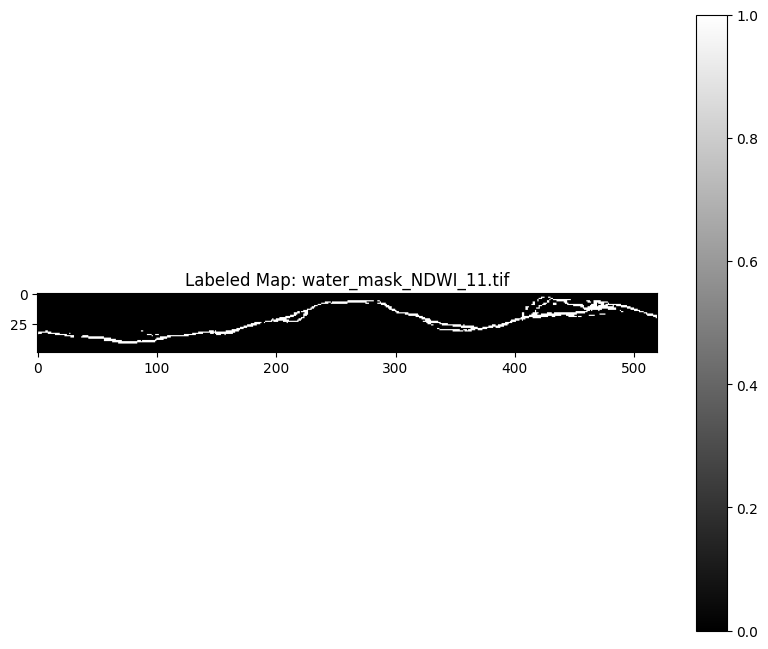

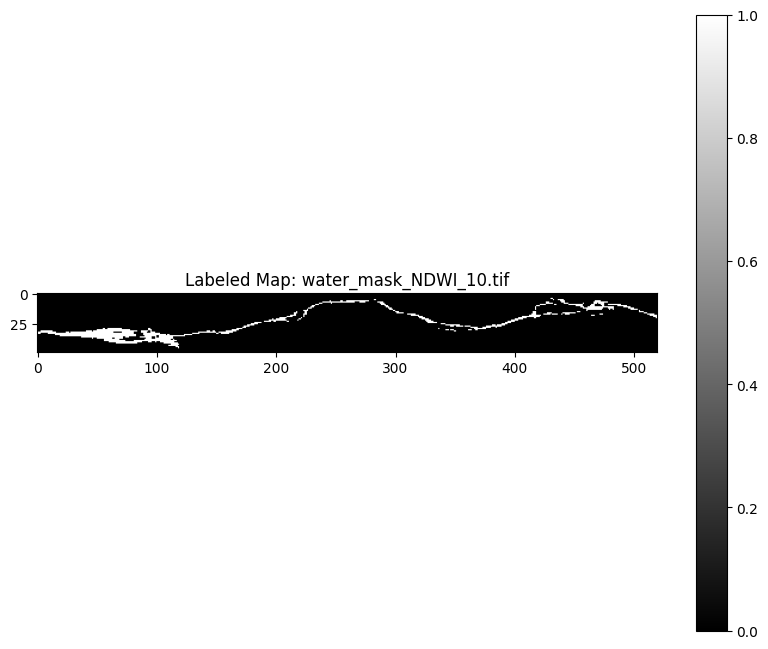

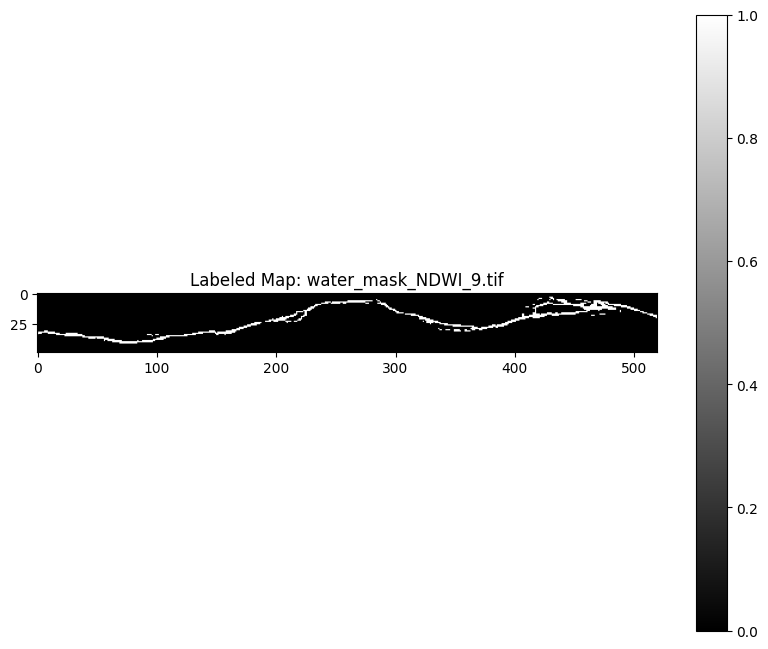

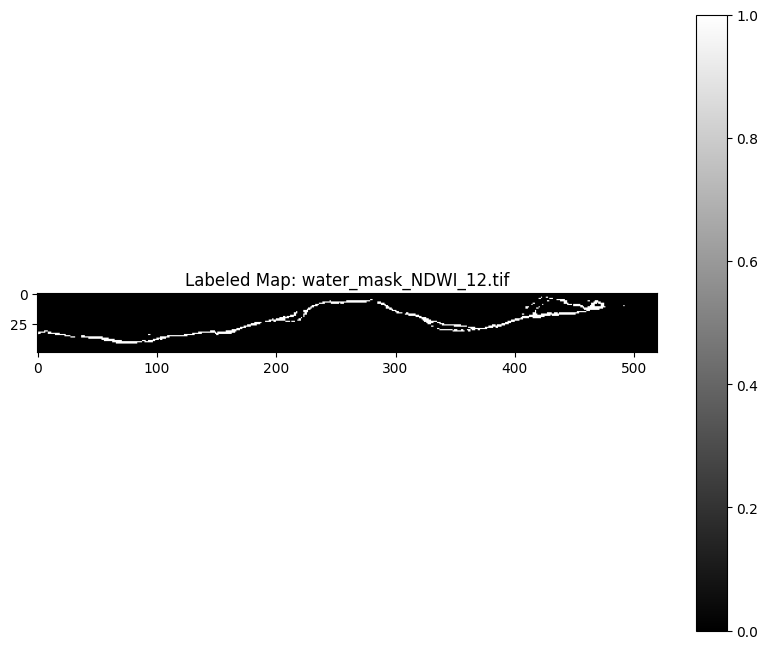

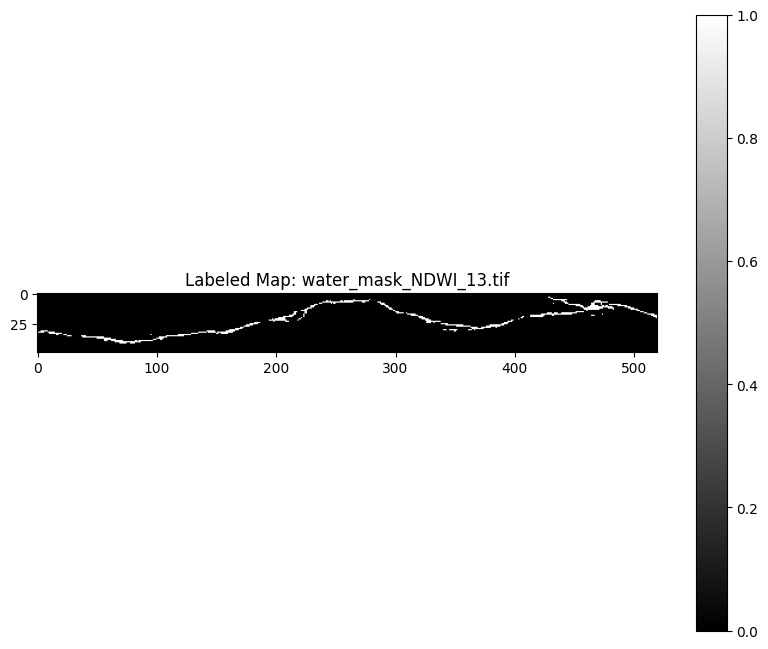

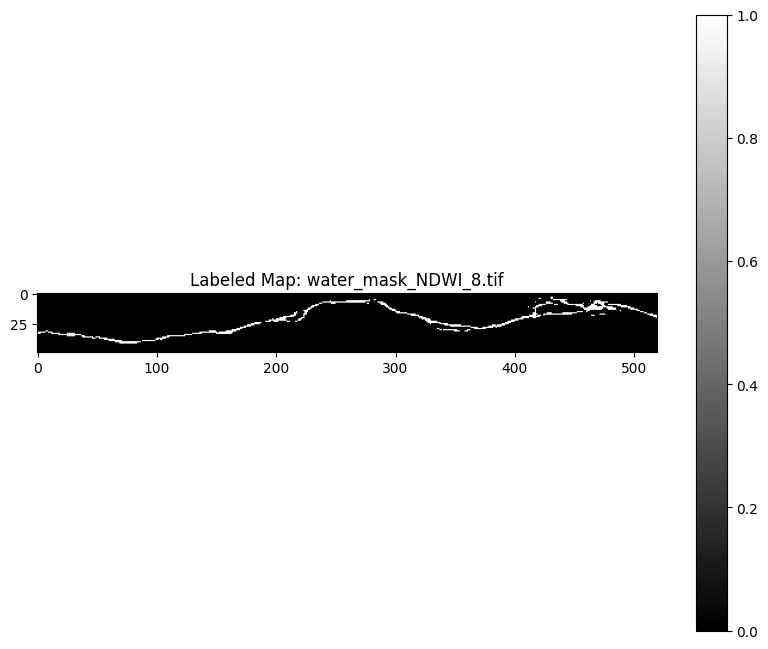

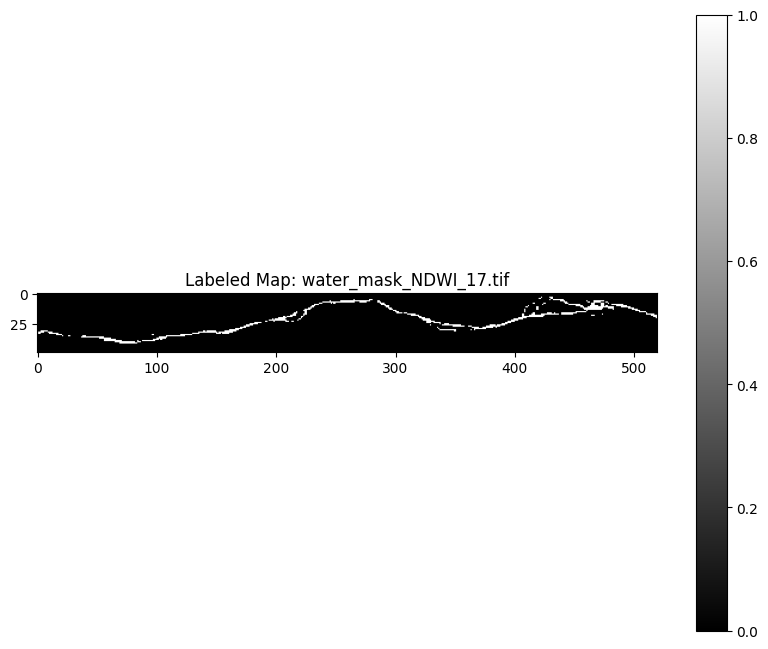

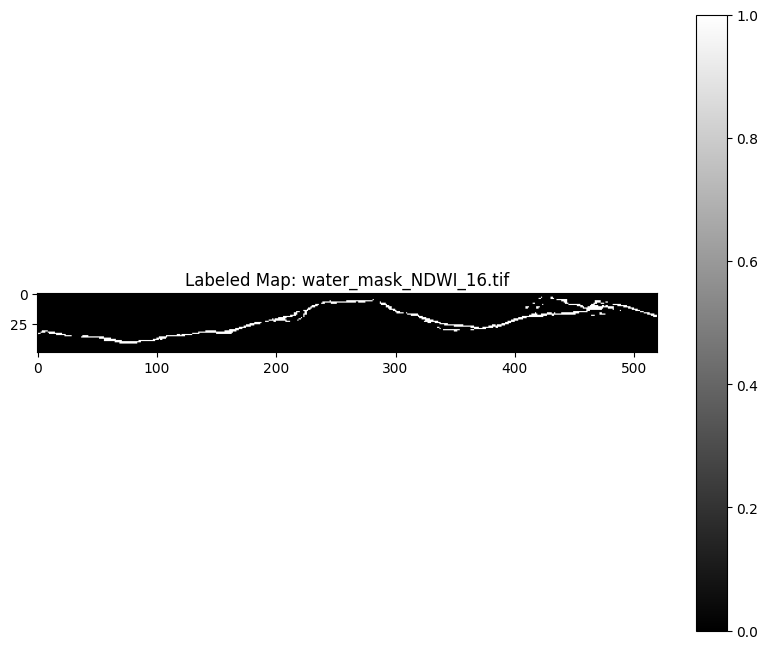

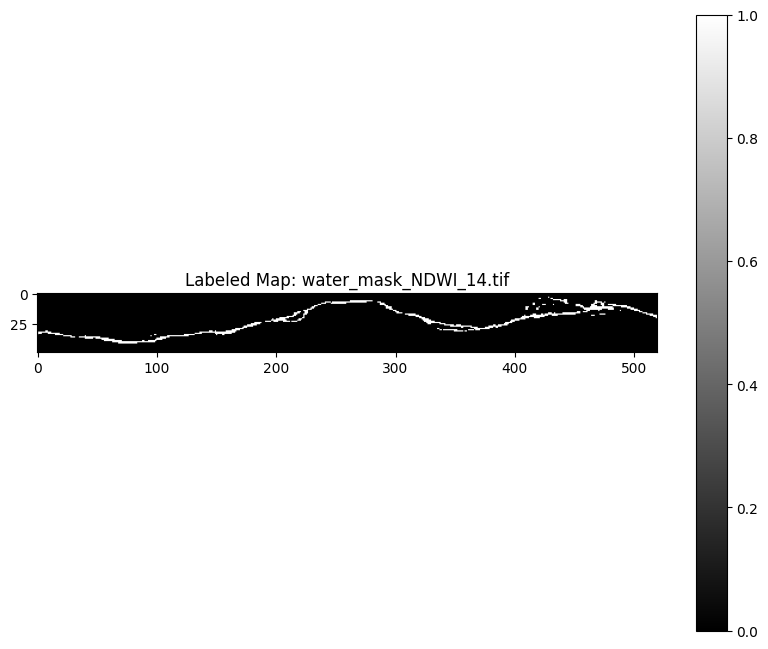

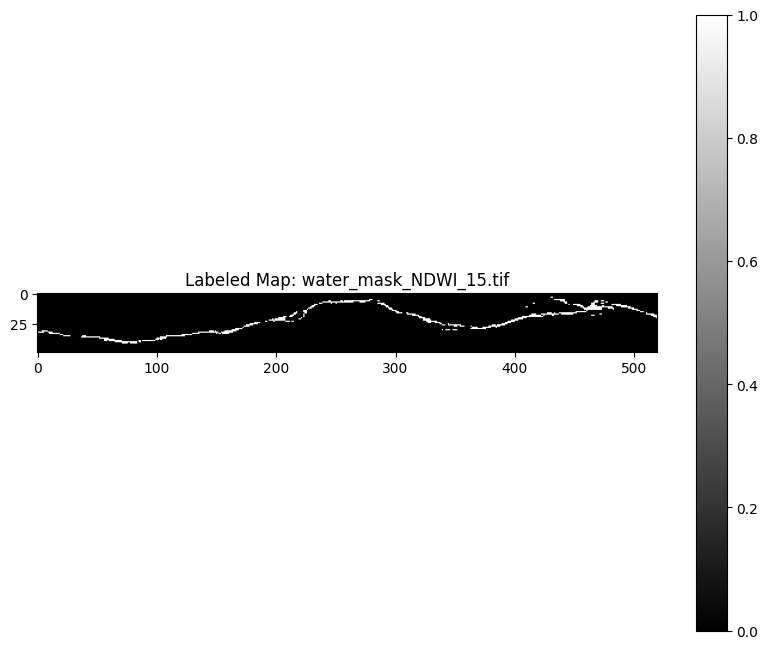

Es wurden 23 Labeled Maps geladen.


In [ ]:
#Step in between: Have a look at the labeled maps and check if they are correct

import numpy as np
import matplotlib.pyplot as plt
import os
from osgeo import gdal

# Pfad zu deinem Ordner mit den Labeled Maps
folder_path = 'water_masks_test_summer/'

# Hole alle TIF-Dateien im Ordner
tif_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.tif')]

# Erstelle eine Liste für die Labeled Maps
labeled_maps = []

# Durchlaufe alle TIF-Dateien und lade sie als Labeled Maps
for tif_file in tif_files:
    file_path = os.path.join(folder_path, tif_file)
    
    try:
        # Öffne das Bild mit gdal
        dataset = gdal.Open(file_path)
        
        # Hole die erste Band (Labeled Map)
        band = dataset.GetRasterBand(1)
        
        # Lese die Bilddaten als NumPy Array
        image_data = band.ReadAsArray()
        
        # Füge die Labeled Map der Liste hinzu
        labeled_maps.append(image_data)
        
        # Zeige das Bild an
        plt.figure(figsize=(10, 8))
        plt.imshow(image_data, cmap='gray')  # Annahme: Es handelt sich um binäre Labeled Maps
        plt.title(f"Labeled Map: {tif_file}")
        plt.colorbar()
        plt.show()
        
        # Schließe das Dataset
        dataset = None
        
    except Exception as e:
        print(f"Fehler beim Laden von {tif_file}: {str(e)}")

# Optional: Wenn du alle Labeled Maps in einem Array hast und mit ihnen weiterarbeiten willst
labeled_maps_array = np.array(labeled_maps)

print(f"Es wurden {len(labeled_maps)} Labeled Maps geladen.")


In [ ]:
#Step 4.1: Prepare images for train data set

import rasterio
import numpy as np
import os
import glob

def load_tif_image(file_path):
    with rasterio.open(file_path) as src:
        # Bilddaten laden (als numpy-Array)
        image = src.read(1)  # Hier nehmen wir den ersten Band des Bildes (Grayscale)
        image = np.expand_dims(image, axis=-1)  # Wir fügen eine zusätzliche Dimension hinzu, falls nötig
    return image

# Funktion, um alle .tif Bilder aus einem Verzeichnis zu laden
def load_all_tif_images(directory):
    image_paths = glob.glob(os.path.join(directory, "*.tif"))
    images = []
    for path in image_paths:
        image = load_tif_image(path)
        images.append(image)
    return np.array(images)

# Beispiel: Lade alle Bilder aus einem Verzeichnis
images_directory = "Labeled_Maps_Isar/"
images = load_all_tif_images(images_directory)


In [ ]:
#Step 4.2: Prepare exogenous factors for train data set

import pandas as pd

# CSV mit den exogenen Faktoren laden
exo_factors_df = pd.read_csv("exo_factors.csv")

# Stellen wir sicher, dass der Datentyp korrekt ist
exo_factors_df['timestamp'] = pd.to_datetime(exo_factors_df['timestamp'])
exo_factors_df['discharge_cum'] = pd.to_numeric(exo_factors_df['discharge_cum'], errors='coerce')
exo_factors_df['precipitation_cum_mm'] = pd.to_numeric(exo_factors_df['precipitation_cum_mm'], errors='coerce')

exo_factors_df = exo_factors_df[['timestamp', 'image_id', 'discharge_cum', 'precipitation_cum_mm']]
# NaN-Werte auffüllen (falls notwendig)
exo_factors_df.fillna(0, inplace=True)

# Nun haben wir die exogenen Faktoren als DataFrame
print(exo_factors_df.head())

# Umwandlung der exogenen Faktoren in ein NumPy-Array (nur die numerischen Spalten)
exo_factors = exo_factors_df[['discharge_cum', 'precipitation_cum_mm']].values

# Falls du sie normalisieren oder anpassen möchtest (optional)
# Zum Beispiel:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# exo_factors = scaler.fit_transform(exo_factors)

# Jetzt hast du ein NumPy-Array mit der Form (n_samples, 2), welches du für das Training verwenden kannst
print(exo_factors.shape)


   timestamp  image_id  discharge_cum  precipitation_cum_mm
0 2020-04-01         0        9860.79                6048.4
1 2020-04-03         1        9868.31                6048.4
2 2020-04-06         2        9879.41                6048.4
3 2020-04-08         3        9886.82                6048.4
4 2020-04-11         4        9897.93                6048.4


In [ ]:
#Step 5: Train data generator for model.fit()

import tensorflow as tf
import numpy as np

def data_generator(images, exo_factors, batch_size, time_steps=5):
    while True:  # Endlos-Schleife, damit der Generator unendlich weiterläuft
        indices = np.random.choice(len(images) - time_steps, batch_size)

        X_images_batch = []  # List für die Batches der Eingabebilder
        exogenous_batch = []  # List für die Batches der exogenen Faktoren
        Y_image_batch = []  # List für die Batches der Zielbilder

        for idx in indices:
            # Erstelle das Batch aus den letzten `time_steps` Bildern
            X_images_batch.append(images[idx:idx+time_steps])
            
            # Erstelle das Batch aus den letzten `time_steps` exogenen Faktoren
            exogenous_batch.append(exo_factors[idx:idx+time_steps])

            # Das Ziel ist das Bild bei `t+1` (also nach den `time_steps`)
            Y_image_batch.append(images[idx + time_steps])

        # Um die richtigen Formen zu erhalten, konvertieren wir Listen in Numpy-Arrays
        X_images_batch = np.array(X_images_batch)
        exogenous_batch = np.array(exogenous_batch)
        Y_image_batch = np.array(Y_image_batch)

        X_images_batch = np.expand_dims(X_images_batch, axis=-1)  # Hinzufügen des Kanals für die Eingabebilder
        Y_image_batch = np.expand_dims(Y_image_batch, axis=-1)  # Hinzufügen des Kanals für die Zielbilder


        # Jetzt konvertieren wir die Arrays in Tensoren
        
        # Gib das Batch als Tensoren zurück
        yield (
            (tf.convert_to_tensor(X_images_batch, dtype=tf.float32),
             tf.convert_to_tensor(exogenous_batch, dtype=tf.float32)),
            tf.convert_to_tensor(Y_image_batch, dtype=tf.float32)
        )


In [5]:
def get_output_signature(images, exo_factors, time_steps=5):
    return (
        (tf.TensorSpec(shape=(None, time_steps, *images.shape[1:]), dtype=tf.float32),  # Eingabebilder
         tf.TensorSpec(shape=(None, time_steps, exo_factors.shape[1]), dtype=tf.float32)),  # Exogene Faktoren
        tf.TensorSpec(shape=(None, *images.shape[1:]), dtype=tf.float32)  # Zielbilder
    )

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(image_shape, exo_input_shape, time_steps):
    # CNN für die Bildverarbeitung (jetzt mit Conv3D und valid padding)
    cnn_input = layers.Input(shape=(time_steps, *image_shape))  # z.B. (5, 49, 520, 1)
    x = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='valid')(cnn_input)  # Weniger Filter und valid Padding
    x = layers.MaxPooling3D((1, 2, 2), padding='valid')(x)  # Pooling mit valid Padding, kleinere Pooling-Größe
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='valid')(x)  # Weniger Filter und valid Padding
    x = layers.MaxPooling3D((1, 2, 2), padding='valid')(x)  # Pooling mit valid Padding, kleinere Pooling-Größe
    x = layers.Flatten()(x)  # Flatten der Ausgabe für die Fully Connected Layer
    
    # LSTM für die exogenen Faktoren
    exo_input = layers.Input(shape=(time_steps, exo_input_shape))  # z.B. (5, 2) für 5 Zeitstempel und 2 Merkmale
    exo_lstm = layers.LSTM(16)(exo_input)  # Weniger LSTM-Einheiten

    # Kombinieren der CNN- und LSTM-Ausgabe
    combined = layers.concatenate([x, exo_lstm])

    # Dense Layer für finale Vorhersage des nächsten Bildes
    output = layers.Dense(image_shape[0] * image_shape[1], activation='sigmoid')(combined)
    output = layers.Reshape((image_shape[0], image_shape[1], 1))(output)  # Umformen zu (49, 520, 1)
    
    # Modell definieren
    model = models.Model(inputs=[cnn_input, exo_input], outputs=output)
    
    return model

# Beispiel: Eingabeformate und Zeitstempel
image_shape = (49, 520, 1)  # z.B. für Grayscale-Bilder
exo_input_shape = 2  # z.B. 2 Merkmale: discharge_cum und precipitation_cum_mm
time_steps = 5  # Angenommen, wir verwenden die letzten 5 Zeitschritte der exogenen Faktoren

# Modell erstellen
model = build_cnn_lstm_model(image_shape, exo_input_shape, time_steps)

# Modell kompilieren
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Modell zusammenfassen
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 5, 49,     │          0 │ -                 │
│ (InputLayer)        │ 520, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 3, 47,     │        224 │ input_layer_8[0]… │
│                     │ 518, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_8     │ (None, 3, 23,     │          0 │ conv3d_8[0][0]    │
│ (MaxPooling3D)      │ 259, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 1, 21,     │      3,472 │ max_pooling3d_8[… │
│                     │ 257, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_9     │ (None, 1, 10,     │          0 │ conv3d_9[0][0]    │
│ (MaxPooling3D)      │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 20480)     │          0 │ max_pooling3d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 16)        │      1,216 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 20496)     │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25480)     │ 522,263,5… │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 49, 520,   │          0 │ dense_4[0][0]     │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 522,268,472 (1.95 GB)

 Trainable params: 522,268,472 (1.95 GB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Beispiel für das Training
train_generator = data_generator(images, exo_factors, batch_size=32, time_steps=5)

# Modell trainieren
model.fit(train_generator, 
          steps_per_epoch=len(images)//32, 
          epochs=10)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 138s 94s/step - accuracy: 0.6575 - loss: 0.6483
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 190s 91s/step - accuracy: 0.9685 - loss: 0.3617
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 185s 96s/step - accuracy: 0.9703 - loss: 0.1598
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 179s 89s/step - accuracy: 0.9689 - loss: 0.1217
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 197s 101s/step - accuracy: 0.9691 - loss: 0.1357
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 186s 99s/step - accuracy: 0.9705 - loss: 0.1353
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 174s 84s/step - accuracy: 0.9708 - loss: 0.1275
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 172s 86s/step - accuracy: 0.9738 - loss: 0.1050
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 174s 86s/step - accuracy: 0.9709 - loss: 0.1216
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 779s 114s/step - accuracy: 0.9702 - loss: 0.1100


In [13]:
# Save the entire model (architecture, weights, and training configuration)
model.save('model/baseline_model.h5')


In [2]:
from tensorflow.keras.models import load_model

# Modell laden (ersetze den Pfad mit dem tatsächlichen Pfad zu deinem Modell)
model = load_model('model/baseline_model.h5')

# Modell zusammenfassen
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 5, 49,     │          0 │ -                 │
│ (InputLayer)        │ 520, 1)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 3, 47,     │        224 │ input_layer_8[0]… │
│                     │ 518, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_8     │ (None, 3, 23,     │          0 │ conv3d_8[0][0]    │
│ (MaxPooling3D)      │ 259, 8)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 1, 21,     │      3,472 │ max_pooling3d_8[… │
│                     │ 257, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_9     │ (None, 1, 10,     │          0 │ conv3d_9[0][0]    │
│ (MaxPooling3D)      │ 128, 16)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 5, 2)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 20480)     │          0 │ max_pooling3d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 16)        │      1,216 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 20496)     │          0 │ flatten_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 25480)     │ 522,263,5… │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 49, 520,   │          0 │ dense_4[0][0]     │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 522,268,474 (1.95 GB)

 Trainable params: 522,268,472 (1.95 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [ ]:
#Step 6: Prepare the test data set

import rasterio
import numpy as np
import os
import glob

def load_tif_image(file_path):
    with rasterio.open(file_path) as src:
        # Bilddaten laden (als numpy-Array)
        image = src.read(1)  # Hier nehmen wir den ersten Band des Bildes (Grayscale)
        image = np.expand_dims(image, axis=-1)  # Wir fügen eine zusätzliche Dimension hinzu, falls nötig
    return image

# Funktion, um alle .tif Bilder aus einem Verzeichnis zu laden
def load_all_tif_images(directory):
    image_paths = glob.glob(os.path.join(directory, "*.tif"))
    images = []
    for path in image_paths:
        image = load_tif_image(path)
        images.append(image)
    return np.array(images)

# Beispiel: Lade alle Bilder aus einem Verzeichnis
images_directory = "water_masks_test_summer/"
images_test = load_all_tif_images(images_directory)

In [64]:
import pandas as pd

#Achtung, habe die falsche column genommen. Brauche discharge!!!

# CSV mit den exogenen Faktoren laden
exo_factors_df = pd.read_csv("exo_test_summer.csv")

# Stellen wir sicher, dass der Datentyp korrekt ist
exo_factors_df['timestamp'] = pd.to_datetime(exo_factors_df['timestamp'])
exo_factors_df['discharge_cum'] = pd.to_numeric(exo_factors_df['discharge_cum'], errors='coerce')
exo_factors_df['precipitation_cum_mm'] = pd.to_numeric(exo_factors_df['precipitation_cum_mm'], errors='coerce')

exo_factors_df = exo_factors_df[['timestamp', 'image_id', 'discharge_cum', 'precipitation_cum_mm']]
# NaN-Werte auffüllen (falls notwendig)
exo_factors_df.fillna(0, inplace=True)

# Nun haben wir die exogenen Faktoren als DataFrame
print(exo_factors_df.head())


   timestamp  image_id  discharge_cum  precipitation_cum_mm
0 2022-05-11         0       13725.17                8424.2
1 2022-05-18         1       13755.89                8448.9
2 2022-06-12         2       13880.81                8610.1
3 2022-06-27         3       13949.07                8690.2
4 2022-06-30         4       13968.37                8730.6


In [65]:
# Umwandlung der exogenen Faktoren in ein NumPy-Array (nur die numerischen Spalten)
exo_factors_test = exo_factors_df[['discharge_cum', 'precipitation_cum_mm']].values

# Falls du sie normalisieren oder anpassen möchtest (optional)
# Zum Beispiel:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# exo_factors = scaler.fit_transform(exo_factors)

# Jetzt hast du ein NumPy-Array mit der Form (n_samples, 2), welches du für das Training verwenden kannst
print(exo_factors_test.shape)

(23, 2)


In [66]:
def create_test_sequences(images_test, exo_factors_test, time_steps=5):
    """
    Erzeugt Eingabesequenzen für das Modell aus Testdaten.
    """
    X_image_seqs = []
    X_exo_seqs = []

    max_start = len(images_test) - time_steps  # Anzahl möglicher Sequenzen

    for i in range(max_start):
        img_seq = images_test[i:i+time_steps]          # → (5, 49, 520, 1)
        exo_seq = exo_factors_test[i:i+time_steps]     # → (5, 2)

        X_image_seqs.append(img_seq)
        X_exo_seqs.append(exo_seq)

    return np.array(X_image_seqs), np.array(X_exo_seqs)


In [67]:
# Testsequenzen erstellen
X_img_seq, X_exo_seq = create_test_sequences(images_test, exo_factors_test)

# Prediction (optional: batch_size setzen)
predicted_images = model.predict((X_img_seq, X_exo_seq))

print(predicted_images.shape)  
# → sollte sein: (8, 49, 520, 1)  wenn time_steps=5 (13 - 5 = 8 mögliche Vorhersagen)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
(18, 49, 520, 1)


In [70]:
Y_true = images_test[5:]  # → entspricht den tatsächlichen Bildern bei t+1 zu jeder Eingabesequenz


In [71]:
# Testsequenzen erstellen
X_img_seq, X_exo_seq = create_test_sequences(images_test, exo_factors_test)

# Prediction (optional: batch_size setzen)
predicted_images = model.predict((X_img_seq, X_exo_seq))

print(predicted_images.shape)  
# → sollte sein: (8, 49, 520, 1)  wenn time_steps=5 (13 - 5 = 8 mögliche Vorhersagen)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 848ms/step
(18, 49, 520, 1)


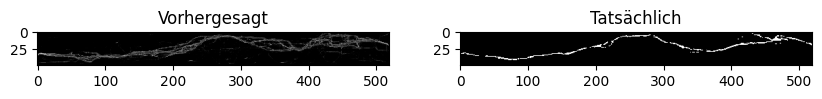

In [85]:
import matplotlib.pyplot as plt

i = 17  # Index eines Beispiels

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Vorhergesagt")
plt.imshow(predicted_images[i].squeeze(), cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Tatsächlich")
plt.imshow(Y_true[i].squeeze(), cmap='gray')
plt.show()


In [59]:
from sklearn.metrics import mean_squared_error

# Berechne den MSE zwischen den tatsächlichen Bildern (Y_true) und den Vorhersagen
mse = mean_squared_error(Y_true.reshape(-1), predicted_images.reshape(-1))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.5028974413871765


In [60]:
import numpy as np

# Berechnung des RMSE
rmse = np.sqrt(np.mean((Y_true - predicted_images) ** 2))
print(f'Root Mean Squared Error (RMSE): {rmse}')

Root Mean Squared Error (RMSE): 0.7091526389122009


In [61]:
import numpy as np

# Setze einen Schwellenwert für binäre Klassifikation (z.B. 0.5)
threshold = 0.5

# Binarisiere die Vorhersagen und die tatsächlichen Bilder
predicted_binary = (predicted_images > threshold).astype(np.uint8)
Y_true_binary = (Y_true > threshold).astype(np.uint8)

# Berechne die Anzahl der richtigen Vorhersagen
correct_predictions = np.sum(predicted_binary == Y_true_binary)

# Berechne die Gesamtzahl der Pixel
total_pixels = np.prod(Y_true_binary.shape)

# Berechne die Accuracy
accuracy = correct_predictions / total_pixels

print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.4695
